<a href="https://colab.research.google.com/github/Nameless8243/TensorFlow/blob/main/TensorFlow_FreeCodeCamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("drive/MyDrive/wine-reviews.csv", usecols = ('country', 'description', 'points', 'price', 'variety', 'winery'))

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=["description", "points"])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


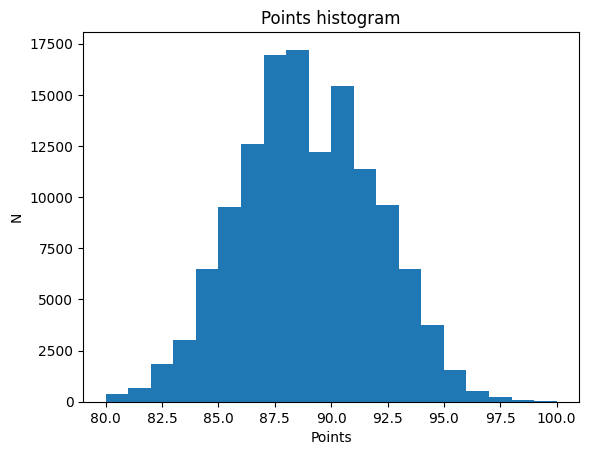

In [6]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [8]:
""" The first split occurs at int(0.8*len(df)),
           which means you're taking the first 80% of the shuffled DataFrame for the training set.
The second split occurs at int(0.9*len(df)),
          which means you're taking the next 10% of the shuffled DataFrame for the validation set.
The remainder (the last 10%) automatically goes to the test set. """

train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)), int(0.9*len(df))]) # 80% train, 10% val, 10% test.

In [9]:
len(train), len(val), len(test)   # So plenty of samples for vals and tests

(103976, 12997, 12998)

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


In [11]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Embedding + Model

Embedding = Transforming text into vector of numbers, so the model can understand.

In [12]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [13]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.62938946, -0.07243829,  0.02891031, ..., -0.0885162 ,
        -0.06797705,  0.22051252],
       [ 0.33106482, -0.23450583, -0.00261891, ...,  0.02510579,
         0.10187636,  0.00232584],
       [ 0.3732997 , -0.14564669,  0.37859726, ..., -0.04579662,
        -0.393422  ,  0.19256976],
       ...,
       [ 0.69986403, -0.11378087,  0.10180374, ..., -0.24881944,
        -0.17893264,  0.03791723],
       [ 0.39858577, -0.17032894,  0.11078423, ..., -0.09028403,
        -0.22400212,  0.16833737],
       [ 0.4462387 , -0.34977582, -0.18243128, ...,  0.18027033,
        -0.240413  , -0.04511194]], dtype=float32)>

## **Build the Model**

In [14]:
"""
  - The line model.add(tf.keras.layers.Dropout(0.4)) adds a dropout layer to your TensorFlow Keras model.
  - Dropout is a regularization technique used to prevent overfitting in neural networks.
  - In this case, 0.4 represents the dropout rate, which is the fraction of the input units to drop during training.
      A dropout rate of 0.4 means that 40% of the input units will be randomly set to zero during each update.
  - tf.keras.layers.Dropout(0.4): This creates a dropout layer with a dropout rate of 0.4.
"""

model = tf.keras.Sequential()
model.add(hub_layer)  # adding the "hub_layer" to the model
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Compile the Model

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

**Evaluate the untrained Model on the "train_data".**

In [16]:
model.evaluate(train_data)

102/102 [==============================] - 7s 41ms/step - loss: 0.6995 - accuracy: 0.4616


[0.6994683742523193, 0.46156805753707886]

**Evaluate the untrained Model on the "valid_data".**




In [17]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 40ms/step - loss: 0.6996 - accuracy: 0.4576


[0.699600100517273, 0.45756712555885315]

In [18]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 193s 2s/step - loss: 0.6305 - accuracy: 0.6322 - val_loss: 0.5127 - val_accuracy: 0.7736
Epoch 2/5
102/102 [==============================] - 164s 2s/step - loss: 0.4881 - accuracy: 0.7681 - val_loss: 0.4112 - val_accuracy: 0.8128
Epoch 3/5
102/102 [==============================] - 159s 2s/step - loss: 0.4120 - accuracy: 0.8210 - val_loss: 0.3859 - val_accuracy: 0.8215
Epoch 4/5
102/102 [==============================] - 188s 2s/step - loss: 0.3766 - accuracy: 0.8424 - val_loss: 0.3794 - val_accuracy: 0.8283
Epoch 5/5
102/102 [==============================] - 202s 2s/step - loss: 0.3529 - accuracy: 0.8531 - val_loss: 0.3807 - val_accuracy: 0.8300


In [19]:
model.evaluate(test_data)

13/13 [==============================] - 2s 189ms/step - loss: 0.3781 - accuracy: 0.8306


[0.37809380888938904, 0.8305892944335938]

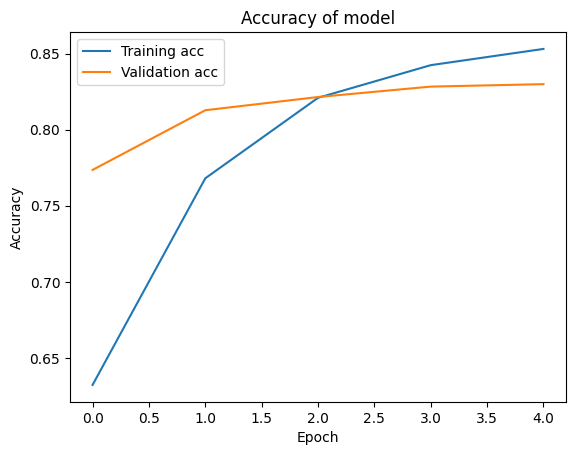

In [20]:
plt.plot(history.history["accuracy"], label="Training acc")
plt.plot(history.history["val_accuracy"], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

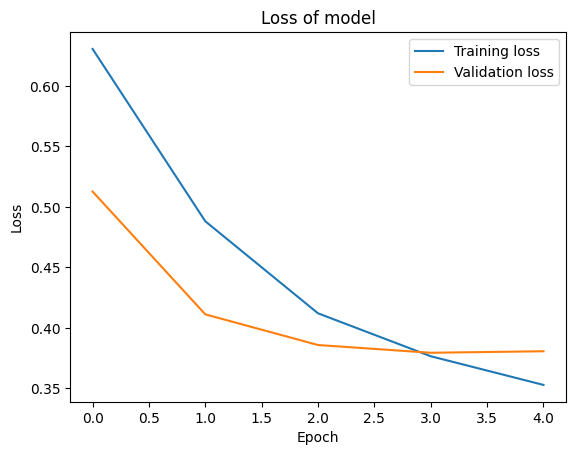

In [21]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## LSTM

### Encoder

In [22]:


encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))


- tf.keras.layers.TextVectorization(max_tokens=2000) creates a text vectorization layer using TensorFlow's Keras API.

- The TextVectorization layer is used for converting raw strings (text) into tokenized sequences or integer indices. It's often used as the first layer in a neural network model for processing text data.

- max_tokens=2000: This parameter sets the maximum vocabulary size that the vectorization layer will maintain. It means that the layer will consider the top 2000 most frequent words in the training dataset and map all other words to an out-of-vocabulary token. This is helpful for limiting the size of the vocabulary and reducing the computational complexity of processing text data.

- Calling encoder.adapt(train_text) allows the layer to analyze the training text data and build its vocabulary based on the specified max_tokens.



### Vocabulary

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]  # first 20 items
#UNK == unknown tokens

 - The code "**vocab = np.array(encoder.get_vocabulary())**" retrieves the vocabulary learned by the "**TextVectorization layer**" (encoder) and stores it as a NumPy array named vocab.

 -  "**encoder.get_vocabulary()**": This method returns the vocabulary learned by the "TextVectorization" layer. The vocabulary is typically a list of strings representing the tokens or words that the layer has encountered and tokenized during its adaptation to the training data.

 - "**np.array(...)**": This converts the vocabulary, which is returned as a Python list of strings, into a NumPy array. NumPy arrays provide convenient methods for numerical operations and array manipulations.

 - By storing the vocabulary in a NumPy array, you can easily perform operations on it using NumPy's functions and methods.

 - After executing the line of code, the variable "**vocab**" will contain the vocabulary learned by the "**TextVectorization**" layer, represented as a NumPy array. Each element of the array corresponds to a token or word in the vocabulary.

### Create the Model

In [27]:
## encoder will vectorise the text
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True  # we can handle variable sequence lengths
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

### Compile the Model

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

### Evaluate the Model

In [30]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 3s 263ms/step - loss: 0.6938 - accuracy: 0.4487


[0.6937764883041382, 0.44871893525123596]

### Train the Model

In [31]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 55s 483ms/step - loss: 0.5489 - accuracy: 0.7109 - val_loss: 0.3802 - val_accuracy: 0.8269
Epoch 2/5
102/102 [==============================] - 48s 467ms/step - loss: 0.3689 - accuracy: 0.8363 - val_loss: 0.3666 - val_accuracy: 0.8313
Epoch 3/5
102/102 [==============================] - 49s 477ms/step - loss: 0.3511 - accuracy: 0.8439 - val_loss: 0.3506 - val_accuracy: 0.8394
Epoch 4/5
102/102 [==============================] - 49s 480ms/step - loss: 0.3408 - accuracy: 0.8500 - val_loss: 0.3489 - val_accuracy: 0.8393
Epoch 5/5
102/102 [==============================] - 51s 495ms/step - loss: 0.3373 - accuracy: 0.8507 - val_loss: 0.3555 - val_accuracy: 0.8384


In [32]:
model.evaluate(test_data)

13/13 [==============================] - 4s 327ms/step - loss: 0.3618 - accuracy: 0.8353


[0.361823707818985, 0.8352823257446289]

**Finished**